In [1]:
import osmnx as ox
import networkx as nx
import pandas as pd
from matplotlib import pyplot as plt
from collections import defaultdict
import numpy as np
import re
import pickle

In [2]:
import trips

In [3]:
place_name="Washington DC, USA"
G = ox.graph_from_place(place_name,network_type='drive', simplify=True)

In [ ]:
#ls=75
ms=np.zeros(99)
for ls in range(0,99):
    b=pd.read_csv('../here-data/speeds_df/df_speeds'+str(ls)+'.csv')
    b.drop(b.loc[b['speeds_rat'] < 0].index, inplace=True)
    b.drop_duplicates(subset=['latitude', 'longitude'], inplace=True)
    ms[ls]=b['speeds_rat'].mean()
    print(ls)
#b=b.reset_index(drop=True)

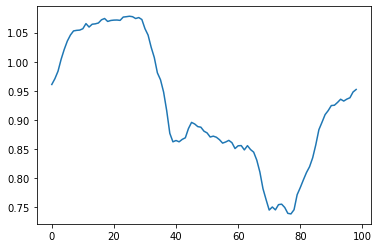

In [14]:
plt.plot(ms)

In [ ]:
#getting nearest edges from HERE traffic files to osmnx
def edges_r(i):
    #dicty=defaultdict(int)
    #for i in range(0,len(b)):
    X=b['longitude'][i]
    Y=b['latitude'][i]
    c,dist=ox.distance.nearest_edges(G, X, Y,return_dist=True)
    (u,v,key)=c
        #edges.loc[u,v]['speed']=b['speeds'][i]
        #dicty[u,v]+=1
    return(u,v,key,dist,b['speeds'][i])

In [42]:
import multiprocessing as mp
import numpy as np
from joblib import Parallel, delayed

In [ ]:
edges_speeds=Parallel(n_jobs=-1,verbose=10)([delayed(edges_r)(i) for i in range(len(b))])

In [ ]:
df_es = pd.DataFrame(edges_speeds)
df_es.to_csv('df_es_75.csv')

In [16]:
#merging speeds file to edges

In [4]:
df_es=pd.read_csv('../df_es_75.csv')

In [5]:
df_es=df_es[['0','1','2','4']]
df_es.columns=['u','v','key','speed']
df_es=df_es.groupby(['u','v','key']).mean().reset_index()
df_es.index=pd.MultiIndex.from_frame(df_es[['u','v','key']])
df_es.columns=['u1','v1','key1','speed']

In [6]:
nodes,edges = ox.graph_to_gdfs(G,fill_edge_geometry=False)
edges2=edges.merge(df_es, left_index=True, right_index=True,how='left')


In [4]:


def add_edge_speeds3(G, edges,hwy_speeds=None, fallback=None, precision=1, agg=np.mean):
    """
    Add edge speeds (km per hour) to graph as new `speed_kph` edge attributes.
    By default, this imputes free-flow travel speeds for all edges via the
    mean `maxspeed` value of the edges of each highway type. For highway types
    in the graph that have no `maxspeed` value on any edge, it assigns the
    mean of all `maxspeed` values in graph.
    This default mean-imputation can obviously be imprecise, and the user can
    override it by passing in `hwy_speeds` and/or `fallback` arguments that
    correspond to local speed limit standards. The user can also specify a
    different aggregation function (such as the median) to impute missing
    values from the observed values.
    If edge `maxspeed` attribute has "mph" in it, value will automatically be
    converted from miles per hour to km per hour. Any other speed units should
    be manually converted to km per hour prior to running this function,
    otherwise there could be unexpected results. If "mph" does not appear in
    the edge's maxspeed attribute string, then function assumes kph, per OSM
    guidelines: https://wiki.openstreetmap.org/wiki/Map_Features/Units
    Parameters
    ----------
    G : networkx.MultiDiGraph
        input graph
    hwy_speeds : dict
        dict keys = OSM highway types and values = typical speeds (km per
        hour) to assign to edges of that highway type for any edges missing
        speed data. Any edges with highway type not in `hwy_speeds` will be
        assigned the mean preexisting speed value of all edges of that highway
        type.
    fallback : numeric
        default speed value (km per hour) to assign to edges whose highway
        type did not appear in `hwy_speeds` and had no preexisting speed
        values on any edge
    precision : int
        decimal precision to round speed_kph
    agg : function
        aggregation function to impute missing values from observed values.
        the default is numpy.mean, but you might also consider for example
        numpy.median, numpy.nanmedian, or your own custom function
    Returns
    -------
    G : networkx.MultiDiGraph
        graph with speed_kph attributes on all edges
    """
    if fallback is None:
        fallback = np.nan

    #edges = ox.graph_to_gdfs(G, nodes=False, fill_edge_geometry=False)

    # collapse any highway lists (can happen during graph simplification)
    # into string values simply by keeping just the first element of the list
    edges["highway"] = edges["highway"].map(lambda x: x[0] if isinstance(x, list) else x)

    if "speed" in edges.columns:
        # collapse any maxspeed lists (can happen during graph simplification)
        # into a single value
        edges["speed"] = edges["speed"].apply(_collapse_multiple_maxspeed_values, agg=agg)

        # create speed_kph by cleaning maxspeed strings and converting mph to
        # kph if necessary
        edges["speed_kph"] = edges["speed"].astype(str).map(_clean_maxspeed).astype(float)
    else:
        # if no edges in graph had a maxspeed attribute
        edges["speed_kph"] = None

    # if user provided hwy_speeds, use them as default values, otherwise
    # initialize an empty series to populate with values
    if hwy_speeds is None:
        hwy_speed_avg = pd.Series(dtype=float)
    else:
        hwy_speed_avg = pd.Series(hwy_speeds).dropna()

    # for each highway type that caller did not provide in hwy_speeds, impute
    # speed of type by taking the mean of the preexisting speed values of that
    # highway type
    for hwy, group in edges.groupby("highway"):
        if hwy not in hwy_speed_avg:
            hwy_speed_avg.loc[hwy] = agg(group["speed_kph"])

    # if any highway types had no preexisting speed values, impute their speed
    # with fallback value provided by caller. if fallback=np.nan, impute speed
    # as the mean speed of all highway types that did have preexisting values
    hwy_speed_avg = hwy_speed_avg.fillna(fallback).fillna(agg(hwy_speed_avg))

    # for each edge missing speed data, assign it the imputed value for its
    # highway type
    speed_kph = (
        edges[["highway", "speed_kph"]].set_index("highway").iloc[:, 0].fillna(hwy_speed_avg)
    )

    # all speeds will be null if edges had no preexisting maxspeed data and
    # caller did not pass in hwy_speeds or fallback arguments
    if pd.isnull(speed_kph).all():
        raise ValueError(
            (
                "this graph's edges have no preexisting `maxspeed` "
                "attribute values so you must pass `hwy_speeds` or "
                "`fallback` arguments."
            )
        )

    # add speed kph attribute to graph edges
    edges["speed_kph"] = speed_kph.round(precision).values
    nx.set_edge_attributes(G, values=edges["speed_kph"], name="speed_kph")

    return G


def _clean_maxspeed(value, convert_mph=True):
    """
    Clean a maxspeed string and convert mph to kph if necessary.
    Parameters
    ----------
    value : string
        an OSM way maxspeed value
    convert_mph : bool
        if True, convert mph to kph
    Returns
    -------
    value_clean : string
    """
    MPH_TO_KPH = 1.60934
    pattern = re.compile(r"[^\d\.,;]")

    try:
        # strip out everything but numbers, periods, commas, semicolons
        value_clean = float(re.sub(pattern, "", value).replace(",", "."))
        if convert_mph and "mph" in value.lower():
            value_clean = value_clean * MPH_TO_KPH
        return value_clean

    except ValueError:
        return None


def _collapse_multiple_maxspeed_values(value, agg):
    """
    Collapse a list of maxspeed values to a single value.
    Parameters
    ----------
    value : list or string
        an OSM way maxspeed value, or a list of them
    agg : function
        the aggregation function to reduce the list to a single value
    Returns
    -------
    agg_value : int
        an integer representation of the aggregated value in the list,
        converted to kph if original value was in mph.
    """
    # if this isn't a list, just return it right back to the caller
    if not isinstance(value, list):
        return value

    else:
        try:
            # clean each value in list and convert to kph if it is mph then
            # return a single aggregated value
            values = [_clean_maxspeed(x) for x in value]
            return int(agg(pd.Series(values).dropna()))
        except ValueError:
            return None

In [8]:
#now adding travel times backed by HERE traffic data for subsequent processing
G1=add_edge_speeds3(G,edges2)
G1 = ox.add_edge_travel_times(G1)
edgesG1=ox.graph_to_gdfs(G1, nodes=False, fill_edge_geometry=False)

In [5]:
OD_in=pd.read_csv('OD_in.csv')

In [ ]:
trips.trips_OD(G1,OD_in,'here75')

In [6]:
routes_raw=pickle.load( open( "routes_raw_tt_iohere75.data", "rb" ) )

In [7]:
routes=np.loadtxt('routes_tt_io2here75.txt')

In [ ]:
trips.tar(routes,routes_raw,'here75')

In [8]:
routes_imp=routes[np.argsort(-1*routes[:,1])] #top node removals

In [10]:
trips2=np.loadtxt('trips_tt_io2here75.txt')

In [ ]:
trips.removal_perc(routes_imp,routes_raw,trips2,'_t_here75')

In [12]:
c_t=np.loadtxt('c_sum_trips_frac_t_here75.txt')

In [15]:
c_t_ff=np.loadtxt('c_sum_trips_frac_t.txt')

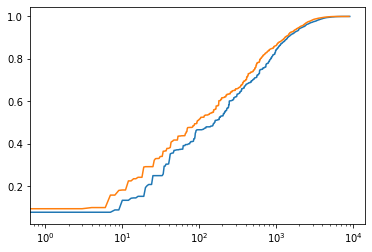

In [16]:
plt.semilogx(c_t)
plt.plot(c_t_ff)

In [ ]:
#iterative removal

tar=np.loadtxt('tar')


routes_it=np.zeros([len(tar),2])
routes_it[:,0]=tar


trips.removal_perc(routes_it,routes_raw,trips2,'_it_here75')

#random removal

routes_ran=routes.copy()
np.random.shuffle(routes_ran)

trips.removal_perc(routes_ran,routes_raw,trips2,'_r_here75')